### Reducing Image size to 32X32

#### Imports

In [ ]:
import os
import cv2
import math

import numpy as np # linear algebra
from PIL import Image
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

#### Load and explore data

Original data from https://www.kaggle.com/c/iwildcam-2019-fgvc6


In [ ]:
label_df = pd.read_csv('../../Downloads/iwildcam-2019-fgvc6/train.csv')
test_df = pd.read_csv('../../Downloads/iwildcam-2019-fgvc6/test.csv')
#submission_df = pd.read_csv('../input/sample_submission.csv')
label_df.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


<AxesSubplot:>

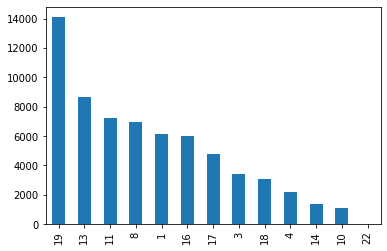

In [ ]:
label_df['category_id'].value_counts()[1:16].plot(kind='bar')


In [ ]:
np.random.randint(0, len(label_df), 16)

array([122555,  94319, 103673, 153453,  44194, 102546,  34890,  80339,
       139058,  33548, 184322,  20214, 175447, 147895,  70216,  42366])

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))

    for i, index in enumerate(np.random.randint(0, len(df), columns*rows)):
        image_path = df.loc[index,'file_name']
        image_id = df.loc[index,'category_id']
        img = cv2.imread(f'../../Downloads/iwildcam-2019-fgvc6/train_images/{image_path}')
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)



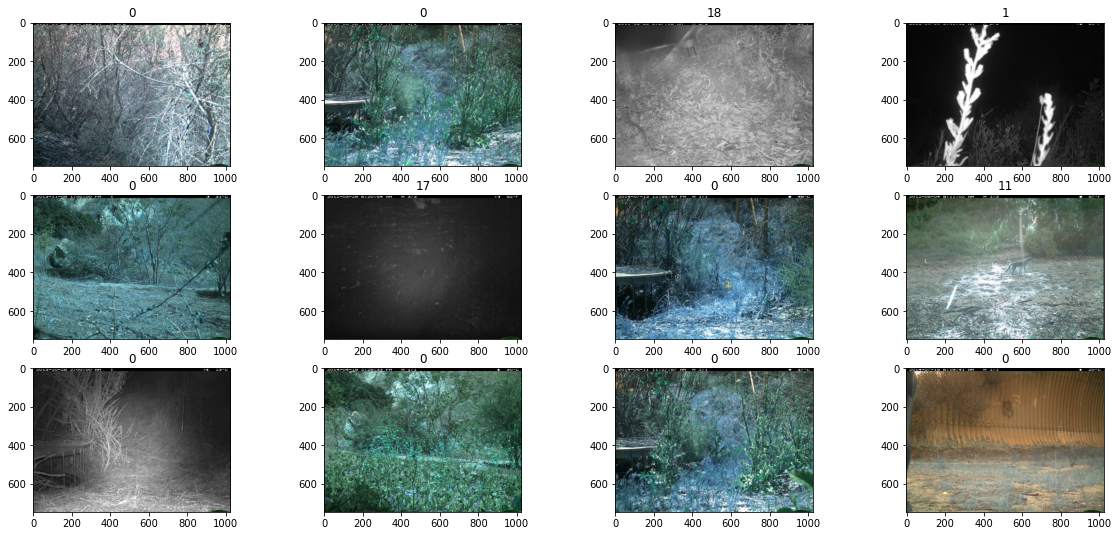

In [ ]:
display_samples(label_df)

#### Utils for resizing

In [ ]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def pad_and_resize(image_path, dataset, pad=False, desired_size=32):
    img = cv2.imread(f'../../Downloads/iwildcam-2019-fgvc6/{dataset}_images/{image_path}.jpg')
    
    if pad:
        pad_width = get_pad_width(img, max(img.shape))
        padded = np.pad(img, pad_width=pad_width, mode='constant', constant_values=0)
    else:
        padded = img
    
    resized = cv2.resize(padded, (desired_size,)*2).astype('uint8')
    
    return resized

#### Resize

In [ ]:
%%time
train_resized_imgs = []
test_resized_imgs = []

for image_id in label_df['id']:
    train_resized_imgs.append(
        pad_and_resize(image_id, 'train')
    )

for image_id in test_df['id']:
    test_resized_imgs.append(
        pad_and_resize(image_id, 'test')
    )


CPU times: user 55min 12s, sys: 3min 40s, total: 58min 53s
Wall time: 1h 54min 21s


In [ ]:
X_train = np.stack(train_resized_imgs)
X_test = np.stack(test_resized_imgs)

target_dummies = pd.get_dummies(label_df['category_id'])
train_label = target_dummies.columns.values
y_train = target_dummies.values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(196299, 32, 32, 3)
(153730, 32, 32, 3)
(196299, 14)


#### Saving

In [ ]:
# No need to save the IDs of X_test, since they are in the same order as the 
# ID column in sample_submission.csv
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)